## Hopfield network with binary nodes

If you are familiar with Ising model you can think of Hopfield network as a generalization of this model, where all the sites are connected not only the nearest neighbors ones that is why it is called network, suggested and studied by John Hopfield in his 1982 paper:
#### Neural Networks and physical systems with emergent collective computational ability

We are interested in the application of this networks in error correction and classification. However we will use physical concepts to understand the behavior of the model and also to design it more efficiently. First we introduce the physical system and then interpret the role of variables and parameters in a machine learnining context.

### Energy function 
Consider a collection of nodes each can assume value 0 or 1, these nodes are fully connected and the connection between node i and j is represented by a tensor $T_{ij}$ called transition matrix, that act as a coupling as it is formulated in the definition of the energy function:

### $E = -\frac{1}{2} V_iT_{ij}V_j - I_jV_j$

In ising model coupling can have any value so if we are only interested in the physical system we must try all the possible value of the coupling, but here we want to design the system so that it is applicable to some machine learning task. More specifically the network can serve as a collection of memories that is fed with a state and asked to associate the state with a memory, this can be considered as error correction or classification. The first question is how to store memories, it must have something to do with the coupling, since the value of parameters are the characteristics of a theory alongside with the dimensionality, we try to find how we can construct coupling given the memory states. Network states lives in a $2^N$ dimensional space for $N=4$, where $N$ stands for the number of nodes, this is a typical state: $\vec{V} = [1,0,0,1]$ the obvious choice to construct a matrix from a vector would be the outer product of it with itself, but at the same time we want this matrix to act as a coupling between nodes by which we mean it tells us how each node tends to pick its value given the value of its neighbor let us have a look at the values of the entries of the matrix constructed from $\vec{V}$ by outer product:
$T_{01} = 0,~ T_{11}=0  $ as we see the pure outer product give same value for having a pair of on and off nodes as well as a pair of off nodes, which is obviously not reflecting the correlation correctly. In order to avoid this deficiency the transition matrix is defined as follows:
$T_{ij} = (2V_i-1)(2V_j-1)$, if  both (ith and jth ) nodes are on or off the corresponding matrix entry is 1 otherwise it is -1 that means to achieve a stable configuration from a given arbitrary state, the positively connected nodes tend to change the value so that they stay positively connected and the same logic is applied to negatively connected nodes. So the physical process of reaching the minimum energy state will be equivalent to the process of remembering a memory which is encoded in the value of couplings. This process is formalized by the following update rule:

### Update Rule:
$x_j = \sum_k T_{jk}V_k + I_j$

if $x_j > 0 \rightarrow V_j = 1,~ x_j<0 \rightarrow V_j = 0$

if $I_j = 0$, $\Delta E = -\Delta V_i \sum T_{ij} V_j$. We see that the above rule tends to minimize the energy. 

If we store more than one memory state then transition matrix is given by:
$T = \sum_i T^i$, where $T^i$ stores the memory $\vec{V}^i$ for when the number of memories to be contained in T is not too large, and the memories not correlated.


#### Code guidance:

In the following block the parameters and libraries are defined and imported.
The functions that return the transition matrix and the result of memory retrieval are defined together with the energy and two helper functions.

In [52]:
node_dim = 2 # each node takes this number of different values, it can be 1,-1 or 0,1
net_size = 4 # the number of nodes in the network 
import numpy as np
import itertools
import matplotlib.pyplot as plt


###########################################################
# Helper function to check if an array is a member of a list

def array_in_list(img, mems):
    for mem in mems:
        count = 0
        for xx in range(len(mem)):
            if mem[xx] == img[xx]:
                count += 1
        if count == len(mem):
            return True
    
    return False


###########################################################
# Constructing the transition matrix according to Hebb rule:

def hebb_matrix(memories): 
    mems = memories
    hebb_list = []
    hebb_list = [np.outer(2*mem-1,2*mem-1) for mem in memories]
    hebb_matrix = sum(hebb_list)
    for mm in range(len(memories[0])):
        hebb_matrix[mm,mm] = 0
    return hebb_matrix


###############################################################
# The function that takes a member of the configuration space: img 
# and returns the associated memory or class for given transition matrix: tmatrix
# I external source: ext_sourc and set of stored memories: memories

def remember(tmatrix, img, ext_source, memories): 
    
    if array_in_list(img, memories):
        x = np.dot(tmatrix, img) + ext_source # x is an arry of shape mem, so ext_source must have the same shape too
        mem = img.copy()

        for i in range(len(x)):
            if x[i] > 0:
                mem[i] = 1
            else:
                mem[i] = 0
            if (mem==img).all():
                break
                return img, "North remembers." # tells that the stored memory is identically restored
        
        return img, "You know nothing Jon Snow."
    # there is something wrong if the function cannot remember 
    #the memory which is stored given the exact state from the memory
        
    else:
        x = np.dot(tmatrix, img) + ext_source # x is an arry of shape mem, so ext_source must have the same shape too
        temp = img.copy()

        for i in range(len(x)):
            if x[i] > 0:
                temp[i] = 1
            elif x[i] <0:
                temp[i] = 0
            
            if array_in_list(temp, memories):
                
                return np.array([temp,img]), "distance=", dist(img,temp), ("Here is Johnny") # The associated memo is found
                break
                
        if not array_in_list(temp, memories):
            return  np.array([temp,img]), "distance=", dist(img,temp), ("Lost in translation") # None of the memos are a match

###############################################################
# The energy function

def energy(transition_matrix, img, ext_source):
    
    tm = transition_matrix
    exs = ext_source
    ee = -0.5*(np.dot(img,np.dot(tm, img))) - np.dot(img, exs) 
    return ee

################################################################
# calculate the distance between different configurations: v and w 1-d numpy array 

def dist(v, w):
    sub = v-w
    dist = sum(abs(sub))
    return dist
   


#### Generating the configuration space

In [53]:
mode = 0 # if -1 , the state of the node are 1, -1 if 0 they are 1,0
num_states = net_size**node_dim # number of all the possible states of the network
if mode == -1:
    node_space = [1, -1]
else:
    node_space = [1,0]

net_states = list(itertools.product(node_space, repeat=net_size))
net_states = [np.array(st) for st in net_states] # the list of all posssible configurations of the network


# memfrac: the fraction of states that are stored in the memory. symmemories: the list of memories
memfrac = 0.3
symmemories = []
symmemories = net_states[:int((memfrac)/2*len(net_states))]
#symmemories = [[1,1,1,1] , [1,0,1,0]]
symmemories = np.array(symmemories)

In [54]:
symmemories

array([[1, 1, 1, 1],
       [1, 1, 1, 0]])

### Study of the theory
Now we want to know how this Hopfield network characterized by the given update rule and hebbian transition matrix is able to retrieve memories. To reach this goal:
* We verify that the network is able to restore memories exactly, which is applying the update rule to each member of memory list.
* We then examine the restoring power of the network on defected memories
* To see the dynamical aspect of this model we plot energy for each update


In [43]:
## dreamorie_long: the list of configuration space that are NOT memory and are to be associated to a memory state
images = net_states.copy()
dreamorie_long = []
dreamorie_long = np.stack([arr for arr in np.stack(images) if not any((arr == elem).all() for elem in symmemories)])

In [44]:
dreamorie_long

array([[1, 1, 0, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 1, 1, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0]])

In [45]:
# nostalgia_long : the result of retrieval action on the dreamorie_long members

trans_matrix = hebb_matrix(symmemories)
ext_source = np.zeros(len(symmemories[0]))
nostalgia_long = []
nostalgia_long = [remember(trans_matrix, img, ext_source, symmemories) for img in dreamorie_long]
nostalgia_long = np.array(nostalgia_long)

<ipython-input-45-bc519b4a9caa>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nostalgia_long = np.array(nostalgia_long)


In [46]:
nostalgia_long

array([[array([[1, 1, 1, 1],
               [1, 1, 0, 1]]), 'dist=', 1, 'Here is Johnny'],
       [array([[1, 1, 1, 0],
               [1, 1, 0, 0]]), 'dist=', 1, 'Here is Johnny'],
       [array([[1, 1, 1, 1],
               [1, 0, 1, 1]]), 'dist=', 1, 'Here is Johnny'],
       [array([[1, 1, 1, 0],
               [1, 0, 1, 0]]), 'dist=', 1, 'Here is Johnny'],
       [array([[1, 1, 1, 1],
               [1, 0, 0, 1]]), 'dist=', 2, 'Here is Johnny'],
       [array([[1, 1, 1, 0],
               [1, 0, 0, 0]]), 'dist=', 2, 'Here is Johnny'],
       [array([[1, 1, 1, 1],
               [0, 1, 1, 1]]), 'dist=', 1, 'Here is Johnny'],
       [array([[1, 1, 1, 0],
               [0, 1, 1, 0]]), 'dist=', 1, 'Here is Johnny'],
       [array([[1, 1, 1, 1],
               [0, 1, 0, 1]]), 'dist=', 2, 'Here is Johnny'],
       [array([[1, 1, 1, 0],
               [0, 1, 0, 0]]), 'dist=', 2, 'Here is Johnny'],
       [array([[1, 1, 1, 1],
               [0, 0, 1, 1]]), 'dist=', 2, 'Here is Johnny'],

### Comparing energy levels of the images and their transformations

In [50]:
nostalgia_long_pairs = nostalgia_long[:,0]
nostalgia_long_pairs = np.stack(nostalgia_long_pairs)

energy_long_madeleine = [energy(trans_matrix, img, ext_source) for img in nostalgia_long_pairs[:,1]]
energy_long_granny = [energy(trans_matrix, img, ext_source) for img in nostalgia_long_pairs[:,0]]
energy_symmemories = [energy(trans_matrix, img, ext_source) for img in symmemories]


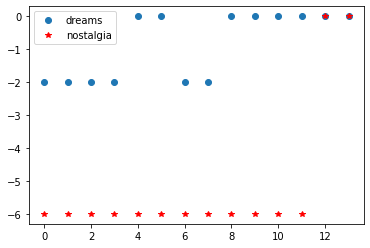

In [57]:
plt.plot(energy_long_madeleine, "o", label="dreams")
plt.plot(energy_long_granny, "*r", label="nostalgia")
#plt.plot(energy_symmemories, "^g", label="memories")
plt.legend()
plt.show()

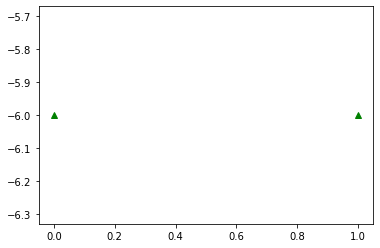

In [56]:
plt.plot(energy_symmemories, "^g", label="memories")
plt.show()

In a future work we investigate the quality of this memory retrieval and how to improve it